In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/pima-indians-diabetes-database/diabetes.csv


# 평가 지표 공부: 피마 인디언 당뇨병 예측

- Dataset: https://www.kaggle.com/uciml/pima-indians-diabetes-database
- Reference: https://github.com/wikibook/pymldg-rev/blob/master/3%EC%9E%A5/3.6%20%ED%94%BC%EB%A7%88%20%EC%9D%B8%EB%94%94%EC%96%B8%20%EB%8B%B9%EB%87%A8%EB%B3%91%20%EC%98%88%EC%B8%A1.ipynb


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

diabetes_data = pd.read_csv('/kaggle/input/pima-indians-diabetes-database/diabetes.csv')
print(diabetes_data['Outcome'].value_counts())
diabetes_data.head(3)

0    500
1    268
Name: Outcome, dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


In [3]:
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
# 수정된 get_clf_eval() 함수 
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [5]:
def precision_recall_curve_plot(y_test=None, pred_proba_c1=None):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

In [7]:
X = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 156, stratify=y)

# 로지스틱 회귀로 학습,예측 및 평가 수행. 
lr_clf = LogisticRegression(solver='liblinear')
lr_clf.fit(X_train , y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test , pred, pred_proba)

오차 행렬
[[87 13]
 [22 32]]
정확도: 0.7727, 정밀도: 0.7111, 재현율: 0.5926,    F1: 0.6465, AUC:0.8083


### 재현율 성능이 낮다. 정밀도 재현율 값의 변화를 확인해보자.

pred_proba_c1 = lr_clf.predict_proba(X_test)[:, 1]
precision_recall_curve_plot(y_test, pred_proba_c1)

임계값을 0.42 정도로 낮추면 recall과 precision이 어느 정도 균형을 맞출 것 같다. 하지만 두 개의 지표 모두 0.7이 안되어 보인다. 데이터를 다시 살펴보자.

In [9]:
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


min이 0인 피쳐가 많이 보인다. Glucose 피처의 값이 0인 것이 말이 되는가?

(array([  5.,   0.,   4.,  32., 156., 211., 163.,  95.,  56.,  46.]),
 array([  0. ,  19.9,  39.8,  59.7,  79.6,  99.5, 119.4, 139.3, 159.2,
        179.1, 199. ]),
 <BarContainer object of 10 artists>)

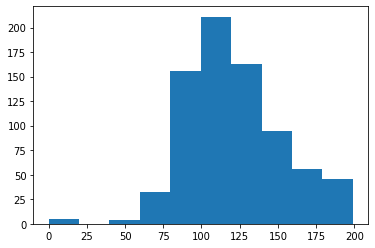

In [10]:
plt.hist(diabetes_data['Glucose'], bins=10)

In [11]:
# 0값을 검사할 피처명 리스트 객체 설정
zero_features = ['Glucose', 'BloodPressure','SkinThickness','Insulin','BMI']

# 전체 데이터 건수
total_count = diabetes_data['Glucose'].count()

# 피처별로 반복 하면서 데이터 값이 0 인 데이터 건수 추출하고, 퍼센트 계산
for feature in zero_features:
    zero_count = diabetes_data[diabetes_data[feature] == 0][feature].count()
    print('{0} 0 건수는 {1}, 퍼센트는 {2:.2f} %'.format(feature, zero_count, 100*zero_count/total_count))

Glucose 0 건수는 5, 퍼센트는 0.65 %
BloodPressure 0 건수는 35, 퍼센트는 4.56 %
SkinThickness 0 건수는 227, 퍼센트는 29.56 %
Insulin 0 건수는 374, 퍼센트는 48.70 %
BMI 0 건수는 11, 퍼센트는 1.43 %


In [12]:
# zero_features 리스트 내부에 저장된 개별 피처들에 대해서 0값을 평균 값으로 대체
diabetes_data[zero_features]=diabetes_data[zero_features].replace(0, diabetes_data[zero_features].mean())

로지스틱 회귀의 경우 일반적으로 숫자 데이터에 스케일링을 적용하는 것이 좋다.

In [13]:
y = diabetes_data.iloc[:, -1]

# StandardScaler 클래스를 이용해 피처 데이터 세트에 일괄적으로 스케일링 적용
scaler = StandardScaler( )
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 156, stratify=y)

# 로지스틱 회귀로 학습, 예측 및 평가 수행. 
lr_clf = LogisticRegression()
lr_clf.fit(X_train , y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test , pred, pred_proba)

오차 행렬
[[90 10]
 [21 33]]
정확도: 0.7987, 정밀도: 0.7674, 재현율: 0.6111,    F1: 0.6804, AUC:0.8059


### 임계값에 따른 평가 지표의 값 변화를 출력해보자

In [14]:
from sklearn.preprocessing import Binarizer

def get_eval_by_threshold(y_test , pred_proba_c1, thresholds):
    # thresholds 리스트 객체내의 값을 차례로 iteration하면서 Evaluation 수행.
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1) 
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임곗값:',custom_threshold)
        get_clf_eval(y_test , custom_predict, pred_proba_c1)

In [15]:
thresholds = [0.3 , 0.33 ,0.36,0.39, 0.42 , 0.45 ,0.48, 0.50]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds )

임곗값: 0.3
오차 행렬
[[69 31]
 [13 41]]
정확도: 0.7143, 정밀도: 0.5694, 재현율: 0.7593,    F1: 0.6508, AUC:0.8059
임곗값: 0.33
오차 행렬
[[74 26]
 [17 37]]
정확도: 0.7208, 정밀도: 0.5873, 재현율: 0.6852,    F1: 0.6325, AUC:0.8059
임곗값: 0.36
오차 행렬
[[76 24]
 [18 36]]
정확도: 0.7273, 정밀도: 0.6000, 재현율: 0.6667,    F1: 0.6316, AUC:0.8059
임곗값: 0.39
오차 행렬
[[79 21]
 [19 35]]
정확도: 0.7403, 정밀도: 0.6250, 재현율: 0.6481,    F1: 0.6364, AUC:0.8059
임곗값: 0.42
오차 행렬
[[81 19]
 [20 34]]
정확도: 0.7468, 정밀도: 0.6415, 재현율: 0.6296,    F1: 0.6355, AUC:0.8059
임곗값: 0.45
오차 행렬
[[85 15]
 [20 34]]
정확도: 0.7727, 정밀도: 0.6939, 재현율: 0.6296,    F1: 0.6602, AUC:0.8059
임곗값: 0.48
오차 행렬
[[88 12]
 [21 33]]
정확도: 0.7857, 정밀도: 0.7333, 재현율: 0.6111,    F1: 0.6667, AUC:0.8059
임곗값: 0.5
오차 행렬
[[90 10]
 [21 33]]
정확도: 0.7987, 정밀도: 0.7674, 재현율: 0.6111,    F1: 0.6804, AUC:0.8059


임계값 0.48 or 0.50에서 recall과 F1 SCORE가 높다. 사이킷런의 predict() 메서드는 임계값을 마음대로 변환할 수 없으므로 별도의 로직으로 이를 구현해야 한다. Binarizer 클래스를 이용하면 된다.

In [16]:
# 임곗값를 0.48로 설정한 Binarizer 생성
binarizer = Binarizer(threshold=0.48)

# 위에서 구한 lr_clf의 predict_proba() 예측 확률 array에서 1에 해당하는 컬럼값을 Binarizer변환. 
pred_th_048 = binarizer.fit_transform(pred_proba[:, 1].reshape(-1,1)) 

get_clf_eval(y_test , pred_th_048, pred_proba[:, 1])

오차 행렬
[[88 12]
 [21 33]]
정확도: 0.7857, 정밀도: 0.7333, 재현율: 0.6111,    F1: 0.6667, AUC:0.8059
